In [4]:
class AlexRipOff:
    
    def __init__(self,number_of_classes,image_height,image_width,train_dataset_path,valid_dataset_path,model_path,epochs,data_loader_batch_size):
        """
        Initiliser of the class where set all the necessary variable that would be accessed by the class methods later.
        """
        self.mood                   = "Have fun"
        self.number_of_classes      = number_of_classes
        self.image_height           = image_height
        self.image_width            = image_width
        self.train_dataset_path     = train_dataset_path
        self.valid_dataset_path     = valid_dataset_path
        self.model_path             = model_path
        self.epochs                 = epochs
        self.data_loader_batch_size = data_loader_batch_size
        self.model                  = Sequential()

   
    def add_conv_layer(self, outputs, kernel_size, strides, padding, activation, kernel_initializer,*input_shape):
        """
        Function to add a Convolution layer to model by taking in inputs and a single arg value to handle the 
        first layer use case.
        """
     
        try:
   
            self.model.add(
                       Conv2D(filters     = outputs, 
                       kernel_size        = kernel_size,
                       strides            = strides,
                       padding            = padding,
                       activation         = activation,
                       input_shape        = input_shape[0],
                       kernel_initializer = kernel_initializer))
        except:
            
            
            self.model.add(
                       Conv2D(filters            = outputs, 
                       kernel_size        = kernel_size,
                       strides            = strides,
                       padding            = padding,
                       activation         = activation,
                       kernel_initializer = kernel_initializer))
    
    def add_max_pooling_layer(self, pool_size, strides, padding ,data_format):
        """
        Function to add a Max Pooling layer to model by taking in inputs.
        """
    
        return self.model.add(
                    MaxPooling2D(pool_size   = pool_size,
                                 strides     = strides,
                                 padding     = padding, 
                                 data_format = None))

    def add_dense_layer(self, units, activation):
        """
        Function to add a Dense layer to model by taking in inputs.
        """
        
        return self.model.add(
                    Dense(units      = units , 
                          activation = activation ))
    
    def add_flatten_layer(self):
        """
        Function to add a Flatten layer to model by taking in inputs.
        """
        
        return self.model.add(Flatten())
    
    def compile_model(self, optimizer, loss, metrics):
        """
        Function to compile the model by taking optimizer , loss function and metric to track as input.
        """
        
        return self.model.compile(optimizer= optimizer,
                            loss= loss,
                            metrics = metrics)
    
    def construct_model(self):
        
        """Most important function where the model is being built step by step using all the above helper functions
        in the class. Adds the layers and compiles the model ready to be used.
        """
        
        
        
        self.add_conv_layer(96, (11,11), 4, 'valid', 'relu','he_normal', (self.image_height, self.image_width, 3) )

        self.add_max_pooling_layer( (3,3), (2,2), 'valid' ,None)
        
        self.add_conv_layer(256, (5,5), 1, 'same', 'relu','he_normal')
        
        self.add_max_pooling_layer( (3,3), (2,2), 'valid' ,None)
        
        self.add_conv_layer(384, (3,3), 1, 'same', 'relu','he_normal')
        
        self.add_conv_layer(384, (3,3), 1, 'same', 'relu','he_normal')
        
        self.add_conv_layer(256, (3,3), 1, 'same', 'relu','he_normal')
        
        self.add_max_pooling_layer( (3,3), (2,2), 'valid' ,None)
        
        self.add_flatten_layer()
        
        self.add_dense_layer(4096, 'relu')
        
        self.add_dense_layer(4096, 'relu')
        
        self.add_dense_layer(1000, 'relu')
        
        self.add_dense_layer(self.number_of_classes, 'softmax')

        self.compile_model(tf.keras.optimizers.Adam(0.0001), 'categorical_crossentropy', ['accuracy'])
        
    
    def image_loaders(self,type_of_data):
        """ Function defining the 
        """
        
        if type_of_data == "train":
        
            data_generator = ImageDataGenerator(rescale            = 1./255,
                                                rotation_range     = 10,
                                                width_shift_range  = 0.1,
                                                height_shift_range = 0.1,
                                                shear_range        = 0.1,
                                                zoom_range         = 0.1)

            data_loader = data_generator.flow_from_directory(self.train_dataset_path,
                                                    target_size = (self.image_height, self.image_width),
                                                    color_mode  = "rgb",
                                                    batch_size  = self.data_loader_batch_size,
                                                    seed        = 1,
                                                    shuffle     = True,
                                                    class_mode  = "categorical")
            return data_loader
        
        elif type_of_data == "validation":
        
            data_generator = ImageDataGenerator(rescale = 1./255)

            data_loader = data_generator.flow_from_directory(self.valid_dataset_path,
                                                    target_size = (self.image_height, self.image_width),
                                                    color_mode  = "rgb",
                                                    batch_size  = self.data_loader_batch_size,
                                                    seed        = 1,
                                                    shuffle     = True,
                                                    class_mode  = "categorical")
            return data_loader
        
        
    def train_model(self):
        """
        Brain function where the training is actually made by fitting our training data and validating it against our 
        validation dataset. The model summary, acccuracy and loss function value is printed.
        """
        
        train_loader = self.image_loaders("train")
        train_number = train_loader.samples
    
        valid_loader = self.image_loaders("validation")
        valid_number = valid_loader.samples


        
    
        model_report = self.model.fit(train_loader,
                                      epochs           = self.epochs,
                                      validation_data  = valid_loader,
                                      verbose          = 2)
        print(self.model.summary())
        
        self.plot_accuracy(model_report)
        
        self.plot_loss(model_report)
        
        self.model.save(model_path)

        
    def plot_accuracy(self,hist):
        """
        Simple plot of epochs vs accuracy function vale for training and validation dataset 

        """
        plt.plot(hist.history["accuracy"])
        plt.plot(hist.history["val_accuracy"])
        plt.title("Model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
 
    def plot_loss(self,hist):
        """
        Simple plot of epochs vs loss function vale for training and validation dataset 
        """
        
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
        plt.title("Model loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        
    def random_image_check(self):
        
        """
        Function takes the validation image loader, used a random batch from the iterator which consists of images 
        equaivalent to the batch size and we take 8 images and print them in blue if the classes match from put prediction
        else in red color.
        """
        
        class_names = os.listdir('test')
        print ("Classes List " + str(class_names))
        print("Class Name Mapping for above list : house_finch, basketball, file, whiskey_jug, pizza")
        
        
        valid_loader = self.image_loaders("validation")

        x_valid, label_batch  = next(iter(valid_loader))

        prediction_values = self.model.predict_classes(x_valid)
        
        fig = plt.figure(figsize=(10, 6))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        for i in range(8):
            ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
            ax.imshow(x_valid[i,:],cmap=plt.cm.gray_r, interpolation='nearest')

            if prediction_values[i] != np.argmax(label_batch[i]):
                ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

            else:
                ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)


        

Found 5288 images belonging to 5 classes.
Found 871 images belonging to 5 classes.
Epoch 1/20


2022-12-07 23:40:28.298360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-07 23:41:22.545085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


441/441 - 57s - loss: 1.2448 - accuracy: 0.4996 - val_loss: 0.7805 - val_accuracy: 0.7210
Epoch 2/20
441/441 - 56s - loss: 0.8861 - accuracy: 0.6721 - val_loss: 1.0695 - val_accuracy: 0.6165
Epoch 3/20
441/441 - 56s - loss: 0.6947 - accuracy: 0.7508 - val_loss: 0.3974 - val_accuracy: 0.8680
Epoch 4/20
441/441 - 56s - loss: 0.6086 - accuracy: 0.7816 - val_loss: 0.4348 - val_accuracy: 0.8519
Epoch 5/20
441/441 - 57s - loss: 0.5040 - accuracy: 0.8219 - val_loss: 0.4106 - val_accuracy: 0.8749
Epoch 6/20
441/441 - 56s - loss: 0.4639 - accuracy: 0.8423 - val_loss: 0.5472 - val_accuracy: 0.8232
Epoch 7/20
441/441 - 56s - loss: 0.3994 - accuracy: 0.8608 - val_loss: 0.3789 - val_accuracy: 0.8645
Epoch 8/20
441/441 - 57s - loss: 0.3505 - accuracy: 0.8786 - val_loss: 0.3001 - val_accuracy: 0.9036
Epoch 9/20
441/441 - 55s - loss: 0.3281 - accuracy: 0.8884 - val_loss: 0.3769 - val_accuracy: 0.8852
Epoch 10/20
441/441 - 55s - loss: 0.2946 - accuracy: 0.8966 - val_loss: 1.0456 - val_accuracy: 0.6762


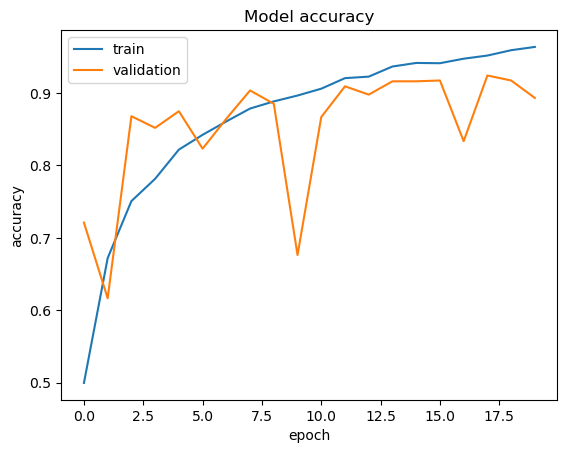

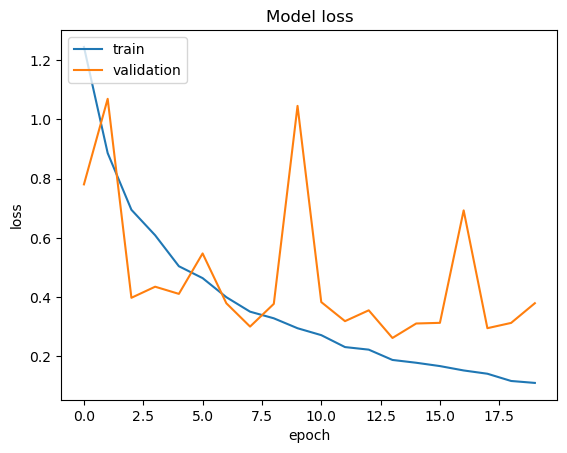

Classes List ['n03337140', 'n02802426', 'n07873807', 'n01532829', 'n04579145']
Class Name Mapping for above list : house_finch, basketball, file, whiskey_jug, pizza
Found 871 images belonging to 5 classes.


2022-12-07 23:58:57.851614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model is run and Completed


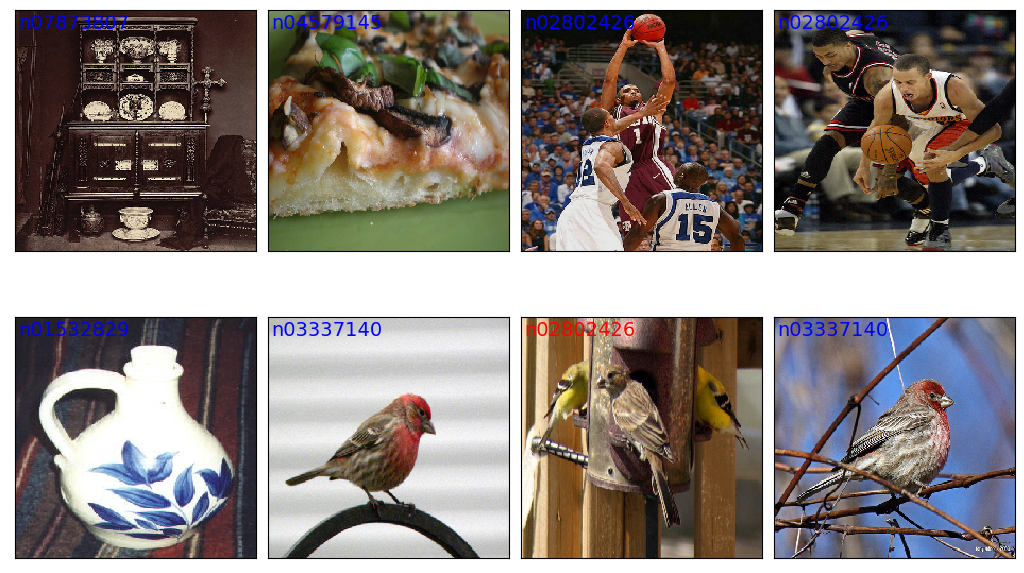

In [6]:
if __name__ == "__main__": 
    
    
    import datetime
    import numpy as np
    import os
    import tensorflow as tf
    import matplotlib.pyplot as plt

    from tensorflow.keras import Model
    from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
    from tensorflow.keras.losses import categorical_crossentropy
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.utils import to_categorical
    ## Making all necessary import from libraries.
    
    epochs                 = 20
    data_loader_batch_size = 12             ## Kept a lower batch size for avoiding OOM error in local.
    image_height           = 227            ## ImageNet Data specification
    image_width            = 227            ## ImageNet Data specification
    train_dataset_path     = "small_folder" ## Training dataset path
    valid_dataset_path     = "test"         ## Testing dataset path
    model_path             = "./alex_rip_off_pizza_included.h5" 
    number_of_classes      = 5              ## Our set consists of 5 classes only.
    
    
    alex_rip_off_model = AlexRipOff(number_of_classes,image_height,image_width,train_dataset_path,valid_dataset_path,model_path,epochs,data_loader_batch_size)
    
    alex_rip_off_model.construct_model()
    
    alex_rip_off_model.train_model()
    
    alex_rip_off_model.random_image_check()
    
    
    print("Model is run and Completed")

    

